# 必要な処理まとめ

考えなくても、必要なことをある程度まとめてできるように
基本の基本の型を作っていきます。

## 流れ

- データを取り込む
- データを理解する
    - データの概要を掴む
    - 目的変数との関係を可視化する

- データの前処理をする
    - 欠損値処理(基本)
        - 中央値で埋める
        - 他の特徴量から欠損値を予測してそれごとに埋める
        - 削除する(欠損値が多過ぎて特徴量として使いにくい時)
    - 文字列データの数字への変換
    
- 予測モデルを立てる

## データを取り込む

In [1]:
# データ分析
import pandas as pd
import pandas_profiling
import numpy as np
import random as rnd

# 可視化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 機械学習
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# データの取り込み
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

# データの前処理用に連結しておくと便利(最後に分割する)
data = pd.concat([train, test], sort = False)

## データを理解する

In [3]:
# ローデータのチェック
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# 欠損値の確認
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# データの概要をまとめてチェックする
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# データの概要をざっくり確認して最初の当たりをつける(処理が重いので、小さめのデータで行う)
# train[:300].profile_report()

# 上のは重いので、軽くみたいならまずは相関係数
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


array([[<AxesSubplot:xlabel='PassengerId', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Survived', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Pclass', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Age', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='SibSp', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Parch', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Fare', ylabel='PassengerId'>],
       [<AxesSubplot:xlabel='PassengerId', ylabel='Survived'>,
        <AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Survived'>,
        <AxesSubplot:xlabel='Parch', ylabel='Survived'>,
        <AxesSubplot:xlabel='Fare', ylabel='Survived'>],
       [<AxesSubplot:xlabel='PassengerId', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Pclass', ylabel='

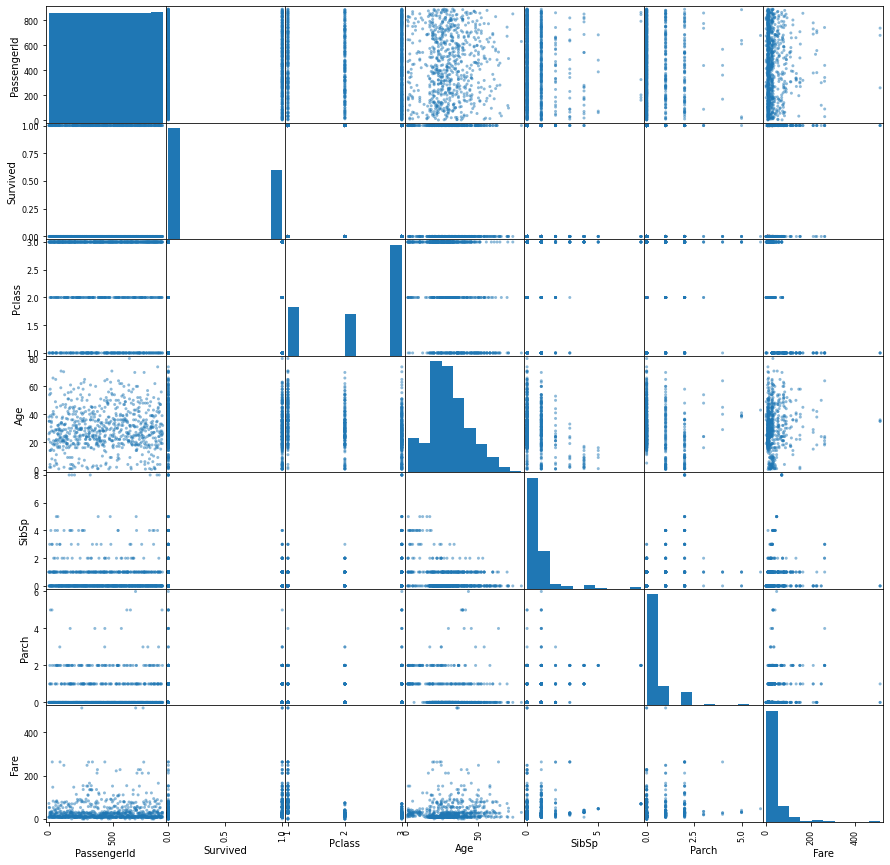

In [7]:
# 散布図行列を作る(pandasプロファイルだと重い場合にざっくり確認用)
pd.plotting.scatter_matrix(train, figsize = (15,15))

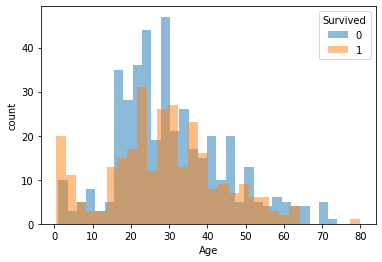

In [8]:
# ヒストグラムでデータを可視化する
plt.hist(train.loc[train['Survived'] == 0, 'Age'].dropna(), bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Age'].dropna(), bins=30, alpha=0.5, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived')
plt.show()

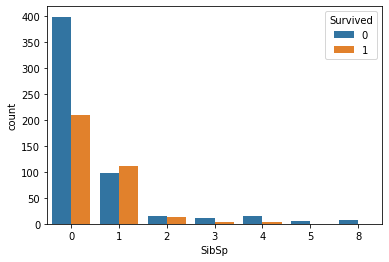

In [9]:
# ビンカウントでデータを可視化する
sns.countplot(x='SibSp', hue='Survived', data=train)
plt.legend(loc='upper right', title='Survived')
plt.show()

In [10]:
# 具体的な数値で関係性を確認をする

train[['SibSp', 'Survived']].groupby(['SibSp']).mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


## データの前処理をする

In [11]:
# 欠損値を補填する
data['Age'].fillna(data['Age'].mean(), inplace = True)
data['Fare'].fillna(data['Fare'].mean(), inplace = True)

In [12]:
# データの最頻値を確認する
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [13]:
# 文字データの数値への対応付(T/Fで記述する)
data['Embarked'].fillna('S', inplace = True)
data = pd.get_dummies(data, columns = ['Embarked', 'Sex'], dtype = int)

In [14]:
data.iloc[:,11:].head(5)

,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0,1,0,1
1,0,0,1,0
2,0,1,1,0
3,0,1,1,0
4,0,1,0,1


In [15]:
# 特徴量同士の演算による新規特徴量の生成
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

data['IsAlone'] = data['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

In [16]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 予測モデルを立てる

In [17]:
# 必要な特徴量だけに絞る
drop_row = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']
train = data[:len(train)]
test = data[len(train):]
X_train = train.drop(drop_row, axis = 1)
Y_train = train['Survived']
X_test = test.drop(drop_row, axis = 1)

In [18]:
# 切り取り方が変じゃないかの確認
X_train.shape, Y_train.shape, X_test.shape

((891, 12), (891,), (418, 12))

In [19]:
# ロジスティック回帰を行う
clf = LogisticRegression(penalty = 'l2', solver = 'sag', random_state = 0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

/Users/aokikento/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [20]:
# 提出用に加工する
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': Y_pred
})